### 執行前注意事項
#### 使用全部14類農地影像，先處理影像大小為需要的尺寸，上傳至個人的雲端硬碟
#### 事先讀取所有影像的label及路徑並儲存檔案, 上傳至個人的雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/AICUP_Full/

In [ ]:
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras import optimizers,backend
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plot
import cv2
import imghdr
import os, math
from random import randint
from datetime import datetime

In [ ]:
# 定義 label
def get_class_list():
  crop_list = ['banana', 'bareland', 'carrot', 'corn', 'dragonfruit', 'garlic', 'guava', 
               'peanut', 'pineapple', 'pumpkin', 'rice', 'soybean', 'sugarcane', 'tomato']
  return crop_list

In [ ]:
# 依label值轉換為類別名稱
def get_class(label_code):
    classes = get_class_list();    
    return classes[label_code]

# 檢視資料影像, 分類及label
def plot_images(Images, Labels, Prediction=[], num=12, show=True):    
    if num > 30: num = 30 
    row = math.ceil(num/6)
    fig, ax = plot.subplots(row, 6, figsize=(24, row*3))
    pic = 1
    for i in range(row):
      for j in range(6):
        if pic <= num:
          idx = randint(0,len(Images)-1)          
          ax[i,j].imshow(Images[idx])  
          title = get_class(Labels[idx])
          if len(Prediction) > 0:
            title = "gt={},p={}".format(title, get_class(Prediction[idx]))                      
          ax[i,j].set_title(title)

        ax[i,j].axis('off')
        pic += 1                                                
    plot.show()

In [ ]:
# 訓練資料
root_dir = '/content/drive/My Drive/Colab Notebooks/AICUP_Full'
train_dir = os.path.join(root_dir, 'dataset', 'train')

In [ ]:
result_dir = '/content/drive/My Drive/Colab Notebooks'

In [ ]:
# 讀取影像路徑及影像對應的label, 已預先儲存在csv
print("make input_paths and labels")
classes = get_class_list()
num_classes = len(classes)
image_paths, labels = [], []

image_paths_file = os.path.join(root_dir, 'train_path_full.csv')

with open(image_paths_file, 'r') as f:
    for line in f:
        line = line.strip().split(',')
        label = int(line[0])
        image_path = os.path.join(root_dir, 'dataset', 'train', line[1].replace('\\','/'))
        labels.append(label)
        image_paths.append(image_path)


print('training images:', len(image_paths))
print('training labels:', len(labels))

In [ ]:
# convert to numpy array
image_paths = np.array(image_paths)
labels = np.array(labels)

# 隨機排序
print("shuffle dataset")
perm = np.random.permutation(len(image_paths))
labels = labels[perm]
image_paths = image_paths[perm]

# split dataset for training and validation
print("split dataset for training and validation")
validation_split = 0.2
border = int(len(image_paths) * validation_split)
val_labels = labels[:border]
val_image_paths = image_paths[:border]
train_labels = labels[border:]
train_image_paths = image_paths[border:]
print("Training on %d images and labels" % (len(train_image_paths)))
print("Validation on %d images and labels" % (len(val_image_paths)))

shuffle dataset
split dataset for training and validation
Training on 64215 images and labels
Validation on 16053 images and labels


In [ ]:
# 讀取影像並顯示
sample_train_images = train_image_paths[:12]
sample_lables = train_labels[:12]
Images, Labels = [], []
for image_path, label in zip(sample_train_images, sample_lables):
  read_image = cv2.imread(image_path) # OpenCV 讀取影像資料  
  read_image = cv2.resize(read_image,(224,224))           
  Images.append(read_image)
  Labels.append(label)

plot_images(Images, Labels)

In [ ]:
# generate data, 訓練時才讀取資料            
def generate_from_paths_and_labels(
        image_paths, labels, batch_size, image_size=(224, 224)):
  num_samples = len(image_paths)
  while True:
    perm = np.random.permutation(num_samples)
    image_paths = image_paths[perm]
    labels = labels[perm]        
    for i in range(0, num_samples, batch_size):
      images = list(map(
                lambda x: image.load_img(x, target_size=image_size),
                image_paths[i:i+batch_size]
            ))
      images = np.array(list(map(
                lambda x: image.img_to_array(x),
                images
            )))         
      yield (images, labels[i:i+batch_size])  

In [ ]:
backend.clear_session()

img_width = 224
img_height = 224
img_bands = 3

# 建構網路
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(img_height,img_height,img_bands), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu')) 
model.add(Dropout(rate=0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='softmax')) 

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
# 模型訓練
train_batch_size = 32
train_epochs = 10
train_image_size=(img_height, img_width)
train_history = model.fit_generator(
    generator=generate_from_paths_and_labels(
        image_paths=train_image_paths,
        labels=train_labels,
        batch_size=train_batch_size,
        image_size=train_image_size
    ),
    steps_per_epoch=math.ceil(
        len(train_image_paths) / train_batch_size),
    epochs=train_epochs,
    validation_data=generate_from_paths_and_labels(
        image_paths=val_image_paths,
        labels=val_labels,
        batch_size=train_batch_size,
        image_size=train_image_size
    ),
    validation_steps=math.ceil(
        len(val_image_paths) / train_batch_size)  
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
2007/2007 [==============================] - 17699s 9s/step - loss: 1.3212 - accuracy: 0.5699 - val_loss: 0.7972 - val_accuracy: 0.7509
Epoch 2/10
2007/2007 [==============================] - 539s 268ms/step - loss: 0.6330 - accuracy: 0.7938 - val_loss: 0.4590 - val_accuracy: 0.8512
Epoch 3/10
2007/2007 [==============================] - 539s 268ms/step - loss: 0.4405 - accuracy: 0.8564 - val_loss: 0.3864 - val_accuracy: 0.8732
Epoch 4/10
2007/2007 [==============================] - 538s 268ms/step - loss: 0.3376 - accuracy: 0.8893 - val_loss: 0.3329 - val_accuracy: 0.8928
Epoch 5/10
2007/2007 [==============================] - 538s 268ms/step - loss: 0.2718 - accuracy: 0.9111 - val_loss: 0.3175 - val_accuracy: 0.8977
Epoch 6/10
2007/2007 [==============================] - 538s 268ms/step - loss: 0.2159 - accuracy: 0.9288 - val_loss: 0.2849 - val_accuracy: 0.9138
Epoch 7/10
2007/2007 [==============================] - 538s 268ms/step - loss: 0.1720 - accuracy: 0.9438 - val_l

In [ ]:
# 儲存模型
model_dir = os.path.join(root_dir, 'vgg16_model')
model.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/AICUP_Full/vgg16_model/assets


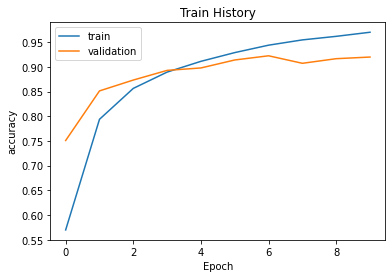

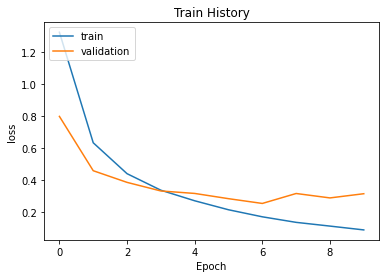

In [ ]:

# 顯示訓練結果
def show_train_history(train_history, train, validation): 
  plot.plot(train_history.history[train])
  plot.plot(train_history.history[validation])
  plot.title('Train History')
  plot.ylabel(train)  
  plot.xlabel('Epoch')  
  plot.legend(['train', 'validation'], loc='upper left')  
  plot.show()
    
show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [ ]:
# 依label值轉換為類別名稱
def get_class(label_code):
    classes = get_class_list();    
    return classes[label_code]

In [ ]:
# 取得訓練集影像及label值
from sklearn.utils import shuffle
def get_images(directory):
    Images = []
    Labels = []
    label = 0
    classes = get_class_list()    
    for folder in os.listdir(directory): # 影像分別儲存在以類別命名的資料夾.
        label = classes.index(folder) # 依資料夾名稱轉換為label值     
        print('資料夾 {} 讀取中 ....'.format(folder))  
        for img_file in os.listdir(os.path.join(directory, folder)):
            image = cv2.imread(os.path.join(directory, folder, img_file)) # OpenCV 讀取影像資料  
            image = cv2.resize(image,(224,224))           
            Images.append(image)
            Labels.append(label)
    
    print('資料已讀取完成.')
    return shuffle(Images,Labels) # 隨機排序

In [ ]:
test_dir = os.path.join(root_dir, 'dataset', 'test')
test_images,test_labels = get_images(test_dir)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of Images:",test_images.shape)
print("Shape of Labels:",test_labels.shape)

資料夾 pumpkin 讀取中 ....
資料夾 peanut 讀取中 ....
資料夾 sugarcane 讀取中 ....
資料夾 dragonfruit 讀取中 ....
資料夾 guava 讀取中 ....
資料夾 pineapple 讀取中 ....
資料夾 garlic 讀取中 ....
資料夾 rice 讀取中 ....
資料夾 tomato 讀取中 ....
資料夾 soybean 讀取中 ....
資料夾 banana 讀取中 ....
資料夾 carrot 讀取中 ....
資料夾 corn 讀取中 ....
資料夾 bareland 讀取中 ....
資料已讀取完成.
Shape of Images: (300, 224, 224, 3)
Shape of Labels: (300,)


In [ ]:
model.evaluate(test_images, test_labels)

10/10 [==============================] - 1s 111ms/step - loss: 0.8901 - accuracy: 0.7900


[0.8901397585868835, 0.7900000214576721]

gt:ground truth, p: prediction



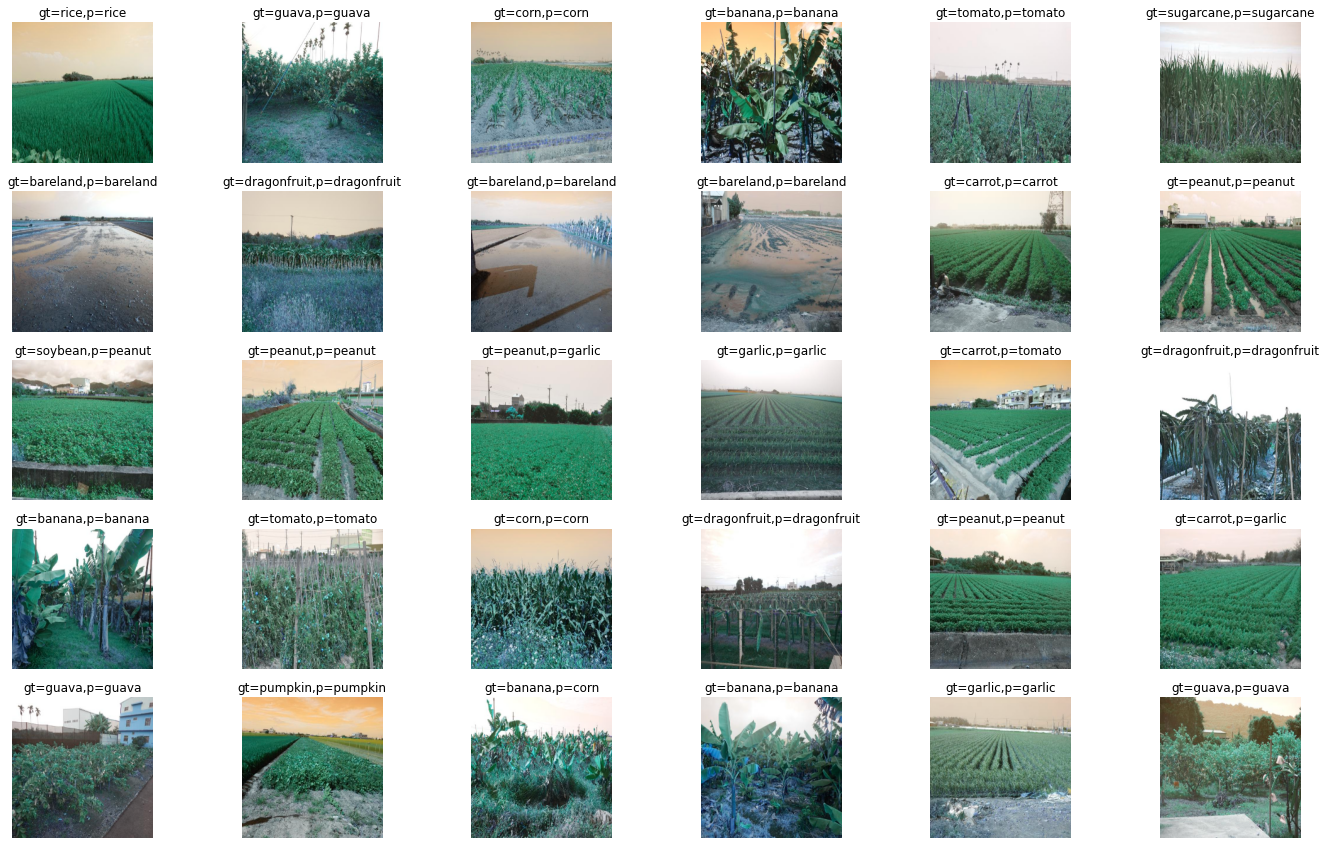

In [ ]:
prediction_prob = model.predict(test_images)
prediction = np.argmax(prediction_prob,axis=1)

print("gt:ground truth, p: prediction\n")
plot_images(test_images, test_labels, prediction, 30)